In [28]:
%reset

In [29]:
import cv2
import os
import numpy as np
from glob import glob                                                 
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

<h3>Keyframe</h3>
A keyframe is a frame where a change occurs in the timeline<br><br>
<img src="kf_exp.png" width=500>

In [30]:
names=[]
with open("coco.names","r") as doc:
    for name in doc.readlines():
        names.append(name.split(",")[0][1:-1])

In [31]:
cap = cv2.VideoCapture('mudhalnee_mudivumnee.mp4')
# print(cap.get(cv2.CAP_PROP_FPS))
prev_frame=cv2.imread("cycle.jpg") #taking some random image for fisrt comparision
key_frames=[]
wh=608 #yolo prefered size
modelConfiguration="yolov3.cfg"
modelweights="yolov3.weights"
net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelweights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
thres_conf=0.5
nms_thres=0.7 #lower means higher no os boxes


det_obj=[]

def find_objects(ouputs,image):
    ht,wd,channels=image.shape
    bbox =[]
    class_ids=[]
    confidence=[]
    for output in outputs:  
        for det in output:
            #lets take all prob of each class and find max
            scores=det[5:] #the first 5 are bbox informations as explained above
            class_id = np.argmax(scores,axis=0) #returns index of max elements np.argmax(array, axis=0)
            confs = scores[class_id] #taking confidence of that prediction
            if confs>thres_conf:
                w,h= int(det[2]*wd),int(det[3]*ht)
                x,y= int ( ( det[0]*wd ) - w/2 ) , int( ( det[1]*ht )- h/2)
                bbox.append((x,y,w,h))
                class_ids.append(class_id)
                confidence.append(float(confs))
    # print(bbox)
    indices=cv2.dnn.NMSBoxes(bbox,confidence,thres_conf,nms_thres) #returns how many objects detected 
    # print("indices",indices)
    fin_ret=[]
    for i in indices:
        box=bbox[i]
        class_name=names[class_ids[i]]
        confi=int(confidence[i]*100)
        fin_ret.append((box,class_name,confi))
    return fin_ret
       

              
while(cap.isOpened()):
    frame_exists, curr_frame = cap.read() #curr_frame consist of matrix representation of image
    if frame_exists==True:
        ######### Key frame extraction #############
        timestamp=cap.get(cv2.CAP_PROP_POS_MSEC)/1000
        
        curr_hist = cv2.calcHist([curr_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
        prev_hist = cv2.calcHist([prev_frame], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])

        curr_hist = cv2.normalize(curr_hist,curr_hist).flatten()
        prev_hist = cv2.normalize(prev_hist,prev_frame).flatten()

        comp=cv2.compareHist(curr_hist , prev_hist ,cv2.HISTCMP_BHATTACHARYYA) #corelation
        # print(comp)
    
        if comp>0.70:
            print("caught a keyframe")
            key_frames.append((prev_frame,curr_frame,timestamp))
        prev_frame=curr_frame

        ######## object detection ###########

        blob=cv2.dnn.blobFromImage(curr_frame,1/255,(wh,wh),[0,0,0],1,crop=False)
        net.setInput(blob)
        layernames=net.getLayerNames()
        # print(net.getUnconnectedOutLayers()) gets the index of output layers
        output_names=[layernames[199],layernames[226],layernames[253]]
        outputs=net.forward(output_names) #gives three outpus from each layer ((1083, 85),(4332, 85),(17328, 85))

        detected_obj=find_objects(outputs,curr_frame)
        det_obj.append((curr_frame,(detected_obj),timestamp))
        print(timestamp)
    else:
        break

cap.release()
# print(timestamps)

caught a keyframe
0.0
0.041666666666666664
0.08333333333333333
0.125
0.16666666666666666
0.20833333333333331
0.25
0.29166666666666663
0.3333333333333333
0.375
0.41666666666666663
0.4583333333333333
0.5
0.5416666666666666
0.5833333333333333
0.625
0.6666666666666666
0.7083333333333333
0.75
0.7916666666666666
0.8333333333333333
0.875
0.9166666666666666
0.9583333333333333
1.0
1.0416666666666665
1.0833333333333333
1.125
1.1666666666666665
1.2083333333333333
1.25
1.2916666666666665
1.3333333333333333
1.375
1.4166666666666665
1.4583333333333333
1.5
1.5416666666666665
1.5833333333333333
1.625
1.6666666666666665
1.7083333333333333
1.75
1.7916666666666665
1.8333333333333333
1.875
1.9166666666666665
1.9583333333333333
2.0
2.0416666666666665
2.083333333333333
2.125
2.1666666666666665
2.208333333333333
2.25
2.2916666666666665
2.333333333333333
2.375
2.4166666666666665
2.458333333333333
2.5
2.5416666666666665
2.583333333333333
2.625
2.6666666666666665
2.708333333333333
2.75
2.7916666666666665
2.8333

<img src="yolo_output_explanation.jpg">

3


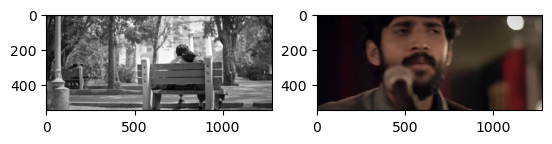

timestamp of this keyframe 14.958333333333332


In [126]:
print(len(key_frames)) #three key frames has been detected
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(key_frames[1][0], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
# image_rgb = 
plt.imshow(cv2.cvtColor(key_frames[1][1], cv2.COLOR_BGR2RGB))    
plt.show()
print("timestamp of this keyframe",key_frames[1][2])

### saving out everything
plt.imsave(f'final_out/{key_frames[1][2]}.jpg',cv2.cvtColor(key_frames[1][0], cv2.COLOR_BGR2RGB))

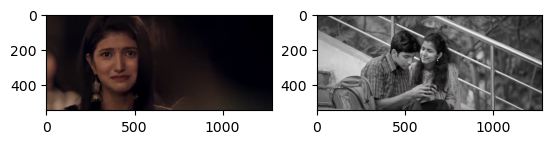

timestamp of this keyframe 60.666666666666664


In [128]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(key_frames[2][0], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(key_frames[2][1], cv2.COLOR_BGR2RGB))
plt.show()

print("timestamp of this keyframe",key_frames[2][2])

plt.imsave(f'final_out/{key_frames[2][2]}.jpg',cv2.cvtColor(key_frames[2][0], cv2.COLOR_BGR2RGB))

In [67]:
# print(det_obj[0][1])
# print("length",len(det_obj[0][1]))
count=0
maxed_out=[0]
for i in det_obj:
    # print(i[1])
    if len(det_obj[0][1])>count:
        maxed_out[0]=i
        count=len(i[1])


In [69]:
maxed_out[0][1]

[((695, 123, 309, 422), 'person', 99),
 ((994, 152, 214, 388), 'person', 99),
 ((661, 348, 254, 192), 'bicycle', 98),
 ((121, 72, 247, 460), 'person', 92),
 ((9, 47, 362, 512), 'person', 83),
 ((7, 96, 208, 414), 'person', 65),
 ((38, 89, 233, 430), 'person', 63),
 ((772, 141, 229, 383), 'person', 62),
 ((42, 175, 215, 296), 'backpack', 53)]

In [76]:
image=maxed_out[0][0]
info=maxed_out[0][1]
timestamp=maxed_out[0][2]
print(info)

[((695, 123, 309, 422), 'person', 99), ((994, 152, 214, 388), 'person', 99), ((661, 348, 254, 192), 'bicycle', 98), ((121, 72, 247, 460), 'person', 92), ((9, 47, 362, 512), 'person', 83), ((7, 96, 208, 414), 'person', 65), ((38, 89, 233, 430), 'person', 63), ((772, 141, 229, 383), 'person', 62), ((42, 175, 215, 296), 'backpack', 53)]


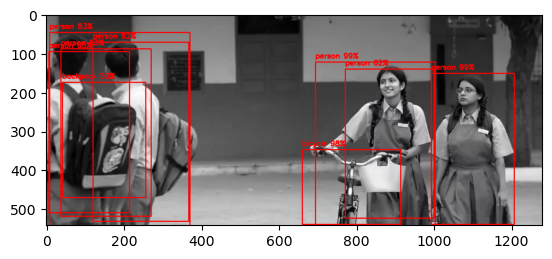

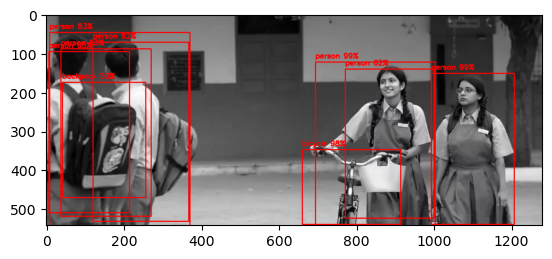

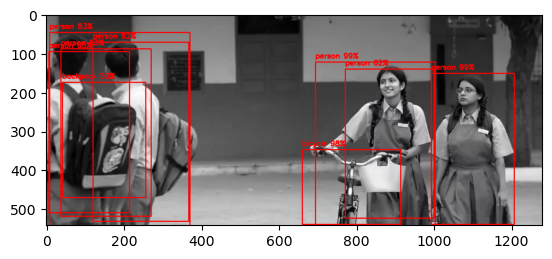

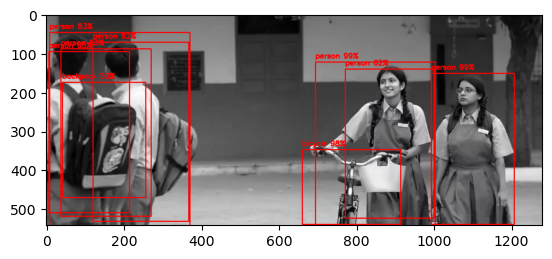

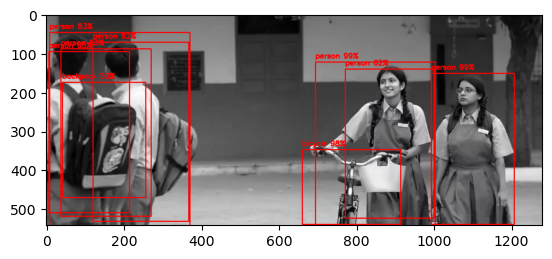

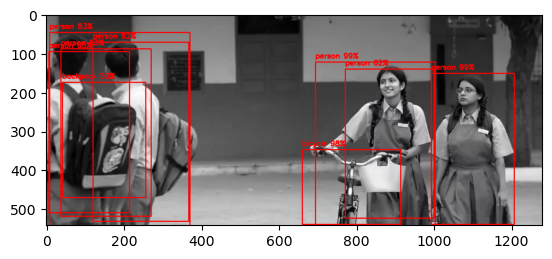

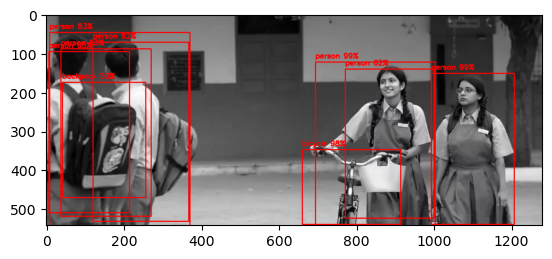

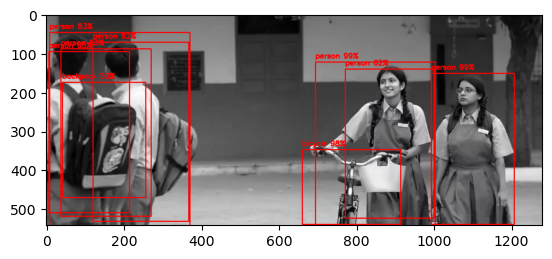

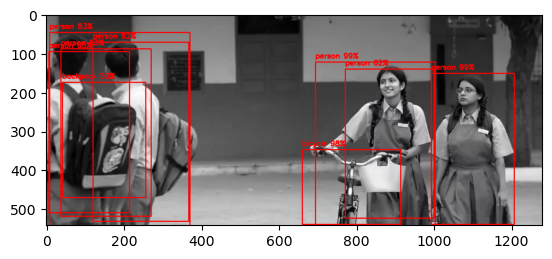

0.0


In [115]:
final=0
for each_box in info:
    x,y,w,h=each_box[0][0],each_box[0][1],each_box[0][2],each_box[0][3]
    temp=cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    final=cv2.putText(image,f'{each_box[1]} {each_box[2]}%',(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2)
    plt.imshow(temp)
    plt.show()
print(timestamp)
# cv2.rectangle(det_obj[0][0],)
# det_obj[0][2]
plt.savefig(f'final_out/{timestamp}.jpg')
plt.imsave(f'final_out/{timestamp}.jpg',final)